<a href="https://colab.research.google.com/github/Hayeoniiii/CIFAR-10-Classification/blob/main/CIFAR-10_CNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CIFAR-10 Dataset download link: https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
!tar -xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
with open("cifar-10-batches-py/data_batch_1", "rb") as f:
    data = pickle.load(f, encoding="bytes")

print(data.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [ ]:
# Trainset
x,y=[],[]
for i in range(1,6):
  with open(f"cifar-10-batches-py/data_batch_{i}", "rb") as f:
      dataset = pickle.load(f, encoding="bytes")
      x.append(dataset[b"data"])
      y.append(dataset[b"labels"])

X_train = np.concatenate(x, axis=0) #(50000,3072)
y_train = np.concatenate(y, axis=0) # (50000, )

# Testset
with open("cifar-10-batches-py/test_batch", "rb") as f:
  test = pickle.load(f, encoding="bytes")

X_test = test[b"data"]
y_test = np.array(test[b"labels"])

In [ ]:
# label_names mapping
with open(("cifar-10-batches-py/batches.meta"), "rb") as f:
    meta = pickle.load(f, encoding="bytes")
print(meta.keys())

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])


In [ ]:
label_names=[name.decode("utf-8)") for name in meta[b"label_names"]]
print(label_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


**CIFAR-10 데이터 저장 방식**

일반적으로 생각하는 이미지 데이터는 `[R, G, B]` 순서로 연속적으로 저장되는 형태이지만, CIFAR-10 데이터셋은 채널별로 데이터를 구분하여 저장하며, 실제 메모리 구조는 다음과 같다:

```
[ R (32×32) ] [ G (32×32) ] [ B (32×32) ]
```

즉, 픽셀 단위로 RGB가 묶여 있는 것이 아니라, 채널 단위로 분리되어 연속적으로 저장된다.  
따라서 단순히 `(32, 32, 3)` 형태로 `reshape`을 수행할 경우 채널 정보가 잘못 매핑되어 색상이 왜곡된 이미지가 생성된다.

이를 올바르게 복원하기 위해서는 먼저 `(3, 32, 32)` 형태로 채널 우선 배열을 구성한 뒤,  
`transpose` 연산을 적용하여 Keras/TensorFlow에서 요구하는 `(32, 32, 3)` 구조로 변환해야 한다.


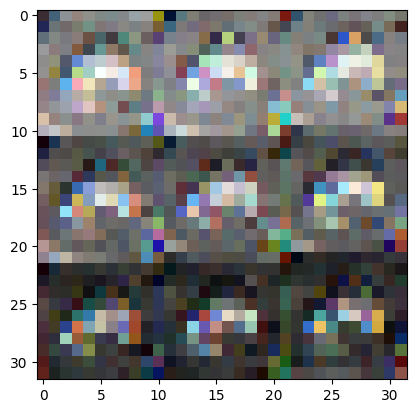

In [ ]:
img=X_train[0].reshape(32,32,3)
plt.imshow(img)

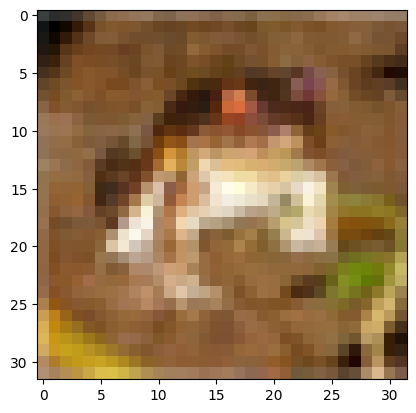

In [ ]:
img2=X_train[0].reshape(3,32,32).transpose(1,2,0)
plt.imshow(img2)

In [ ]:
# reshape
X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_train = y_train.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]])

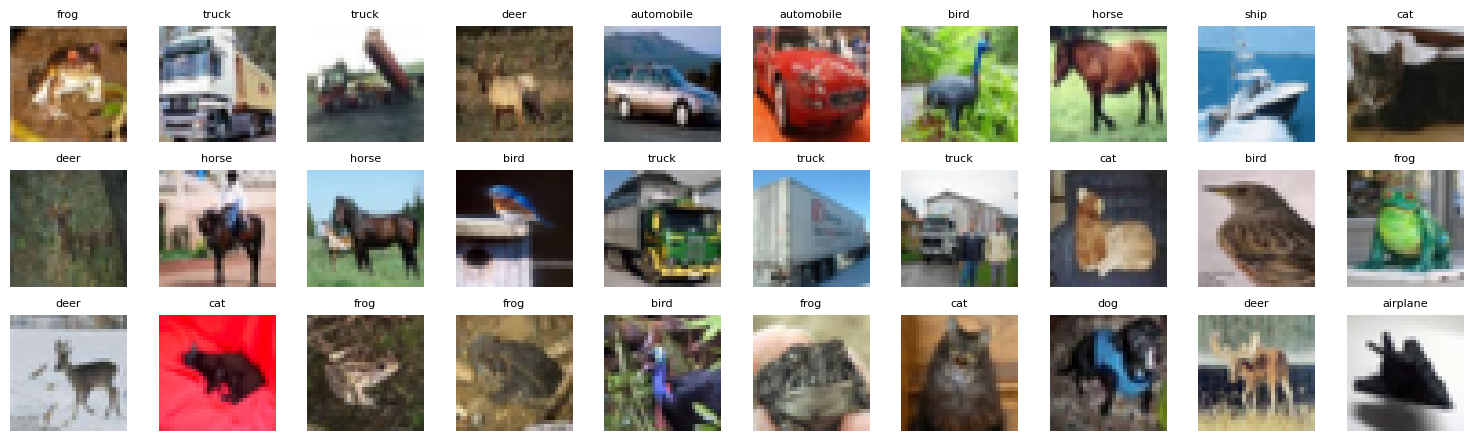

In [ ]:
# Dataset Visualization
rows=3
cols=10

y=y_train.squeeze()
n=rows*cols

plt.figure(figsize=(cols*1.5, rows*1.5))
for i in range(n):
  ax=plt.subplot(rows, cols, i+1)
  img=X_train[i]
  ax.imshow(img)
  ax.set_title(label_names[y[i]], fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

# one-hot-encoding
y_train = to_categorical(y_train, num_classes=10)
y_test  = to_categorical(y_test, num_classes=10)

In [ ]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', input_shape=(32,32,3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Data Augmentation

datagen = ImageDataGenerator(
    width_shift_range=0.1,     # Shift
    height_shift_range=0.1,
    horizontal_flip=True,      # Horizontal flip
    zoom_range=0.1             # zoom
)

epochs: 20<br>
batch size: 64<br>
Batch Normalization 적용<br>
Data Augmentation (shift, horizontal flip, zoom)

In [ ]:
history=model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=20
)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.3980 - loss: 1.7455 - val_accuracy: 0.4178 - val_loss: 2.0330
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.6309 - loss: 1.0420 - val_accuracy: 0.6794 - val_loss: 0.8818
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.6983 - loss: 0.8555 - val_accuracy: 0.6492 - val_loss: 0.9922
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.7356 - loss: 0.7607 - val_accuracy: 0.7466 - val_loss: 0.7625
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.7608 - loss: 0.6876 - val_accuracy: 0.7562 - val_loss: 0.7078
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.7779 - loss: 0.6376 - val_accuracy: 0.7534 - val_loss: 0.7086
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.7943 - loss: 0.5939 - val_accuracy: 0.7812 - val_loss: 0.6526
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.8094 - loss: 0.5532 - 

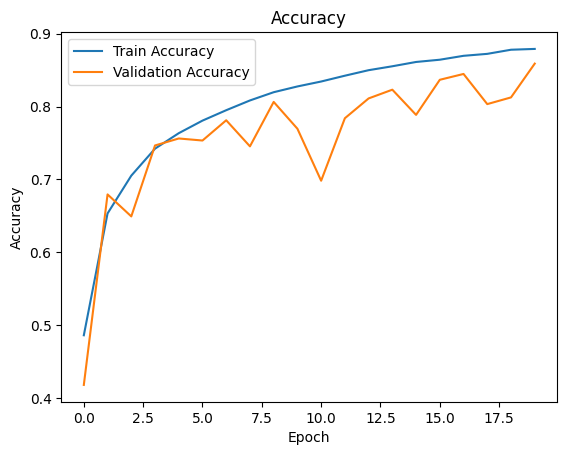

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8567 - loss: 0.4381


[0.433977872133255, 0.857200026512146]